# Project 2 EDA Notebook: Budget Analysis

In [147]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from zipfile import ZipFile # for unzipping the db.zip file
import scipy.stats as stats
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None) # show all columns when printing out dataframe
plt.style.use("fivethirtyeight")
plt.grid(False)
%matplotlib inline

In [148]:
df = pd.read_csv("../zippedData/cleaned_budget_data.csv")

In [149]:
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_profit,movie_year,date_time,roi,two_x,quartile
0,1,"Dec 18, 2009",Avatar,425.0,760.508,2776.345,2351.345,2009,2009-12-18,5.532576,1,Top 25
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,635.064,2011,2011-05-20,1.546673,1,Top 25
2,3,"Jun 7, 2019",Dark Phoenix,350.0,42.762,149.762,-200.238,2019,2019-06-07,-0.572109,0,Top 25
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014,1072.414,2015,2015-05-01,3.243842,1,Top 25
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.181,1316.722,999.722,2017,2017-12-15,3.153697,1,Top 25


In [150]:
# Creates separate budget tiers of interest for further exploration
hundred = df.loc[df["production_budget"] > 100.00000]
forty = df.loc[(df["production_budget"] <= 100.00000) & (df["quartile"] == "Top 25")]
inner = df.loc[(df["quartile"] == "25-50") | (df["quartile"] == "50-75")]
bottom = df.loc[df["quartile"] == "Bottom 25"] 

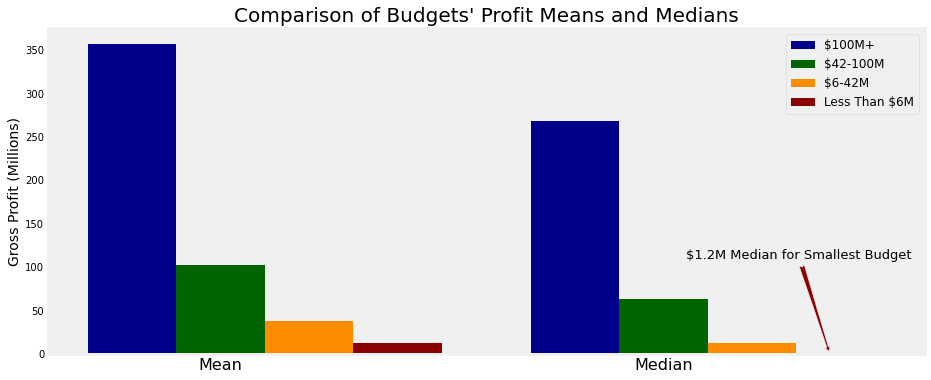

In [151]:
# Create a plot to display the means/medians of profit at the different budget tier levels
labels = ['Mean', 'Median']
h = np.array([hundred["gross_profit"].mean(), hundred["gross_profit"].median()])
f = np.array([forty["gross_profit"].mean(), forty["gross_profit"].median()])
i = np.array([inner["gross_profit"].mean(), inner["gross_profit"].median()])
b = np.array([bottom["gross_profit"].mean(), bottom["gross_profit"].median()])

width = 0.2

# Create the conditions/locations for bars on the x-axis
x = np.arange(len(labels))
x_h = x - width
x_f = x
x_i = x + width
x_b = x + 2 * width

fig, ax = plt.subplots(figsize=(14,6))

ax.bar(x_h, h, width, color='darkblue', alpha=1, label='Hundred')
ax.bar(x_f, f, width, color='darkgreen', alpha=1, label='Forty')
ax.bar(x_i, i, width, color='darkorange', alpha=1, label='Inner')
ax.bar(x_b, b, width, color='darkred', alpha=1, label='Bottom')

ax.set_xticks(x) 
ax.set_xticklabels(labels, fontsize=16) 
ax.legend() 
ax.set_xlabel('')
ax.set_ylabel('Gross Profit (Millions)', fontsize=14)
ax.set_title('Comparison of Budgets\' Profit Means and Medians', fontsize='20')
ax.legend(["$100M+", "$42-100M", "$6-42M", "Less Than $6M"], fontsize='large')
plt.annotate(text="$1.2M Median for Smallest Budget", xy=(1.375, 1.3), xytext=(1.05, 110), arrowprops=dict(
    facecolor='darkred', arrowstyle='fancy'), fontsize=13)
plt.grid(False);

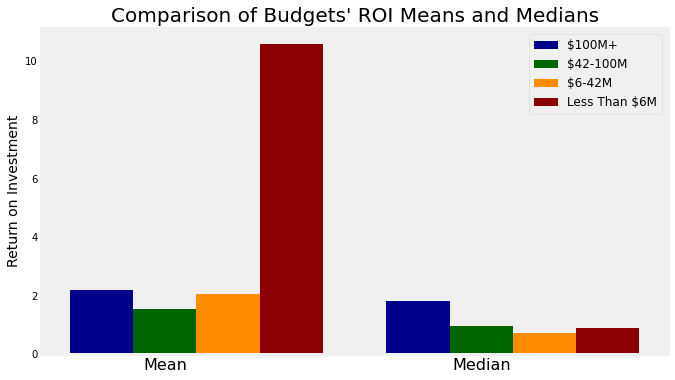

In [152]:
# Plotting the same as above but for ROI's instead of profits
labels = ['Mean', 'Median']
h = np.array([hundred["roi"].mean(), hundred["roi"].median()])
f = np.array([forty["roi"].mean(), forty["roi"].median()])
i = np.array([inner["roi"].mean(), inner["roi"].median()])
b = np.array([bottom["roi"].mean(), bottom["roi"].median()])

width = 0.2

# Create the conditions/locations for bars on the x-axis
x = np.arange(len(labels))
x_h = x - width
x_f = x
x_i = x + width
x_b = x + 2 * width

fig, ax = plt.subplots(figsize=(10,6)) 


ax.bar(x_h, h, width, color='darkblue', alpha=1, label='Hundred')
ax.bar(x_f, f, width, color='darkgreen', alpha=1, label='Forty')
ax.bar(x_i, i, width, color='darkorange', alpha=1, label='Inner')
ax.bar(x_b, b, width, color='darkred', alpha=1, label='Bottom')

ax.set_xticks(x) 
ax.set_xticklabels(labels, fontsize=16) 
ax.legend() 
ax.set_xlabel('') 
ax.set_ylabel('Return on Investment', fontsize=14)
ax.set_title('Comparison of Budgets\' ROI Means and Medians', fontsize='20')
ax.legend(["$100M+", "$42-100M", "$6-42M", "Less Than $6M"], fontsize='large')
plt.grid(False)

## The plot below displays the most profitable movies on record without any budget filters in place.

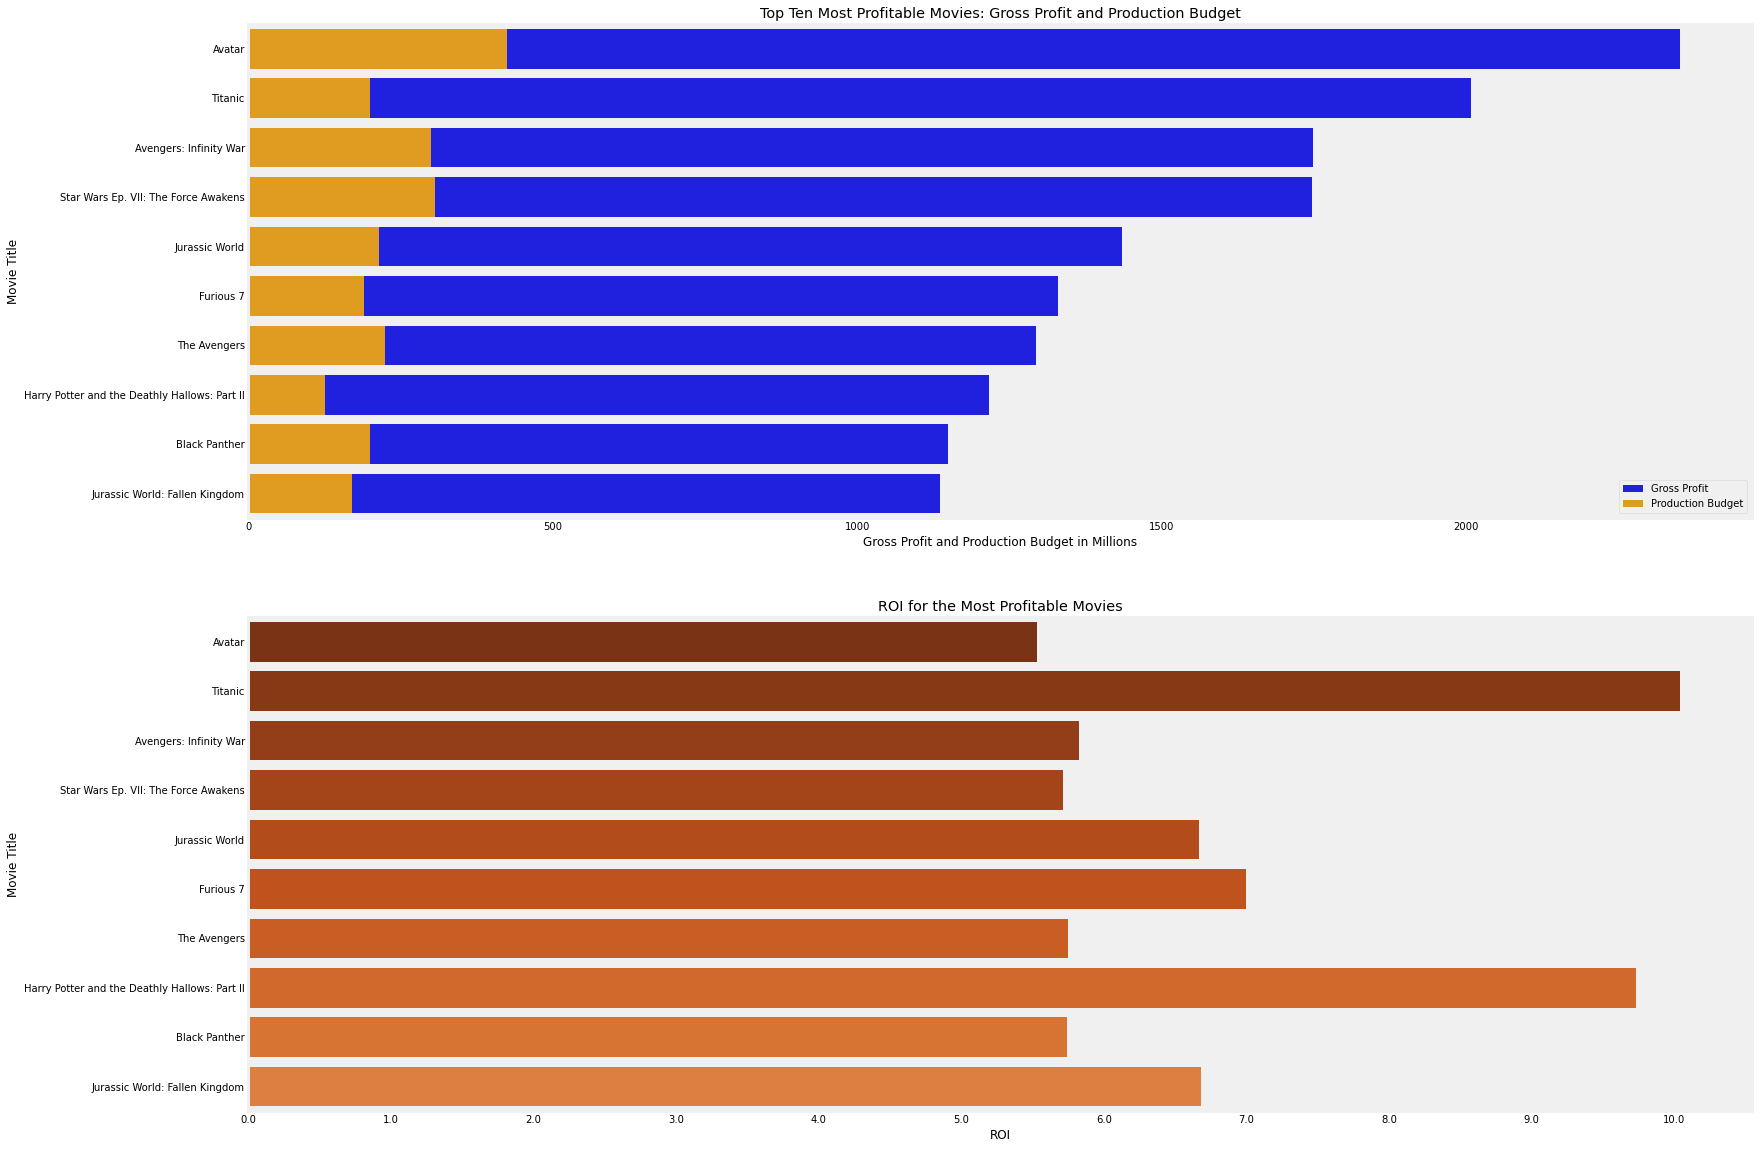

In [153]:
## Plotting Profit vs Budget for the Movies with the largest gross profit
fig, ax = plt.subplots(nrows=2, figsize=(24,20))

# Creates new df object to assist with plotting 
top_movies = df.sort_values(by='gross_profit', ascending=False)[:10]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax[0], label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax[0], label='Production Budget')

ax[0].set_xlabel("Gross Profit and Production Budget in Millions")
ax[0].set_ylabel("Movie Title")
ax[0].set_title("Top Ten Most Profitable Movies: Gross Profit and Production Budget")
ax[0].legend()
ax[0].grid(False)
plt.xticks(np.arange(0, 2420, 100))

greens = sns.color_palette("Oranges_r", 22)
sns.barplot(x='roi', y='movie', data=top_movies, ax=ax[1], palette=greens)
ax[1].set_xlabel("ROI")
ax[1].set_ylabel("Movie Title")
ax[1].set_xticks(np.arange(0, top_movies['roi'].max(), 1))
ax[1].set_xticklabels(np.arange(0, top_movies['roi'].max(), 1))
ax[1].set_title("ROI for the Most Profitable Movies")
plt.grid(False);

## This plot shows the movies with the largest losses on record, once again without any budget filters.

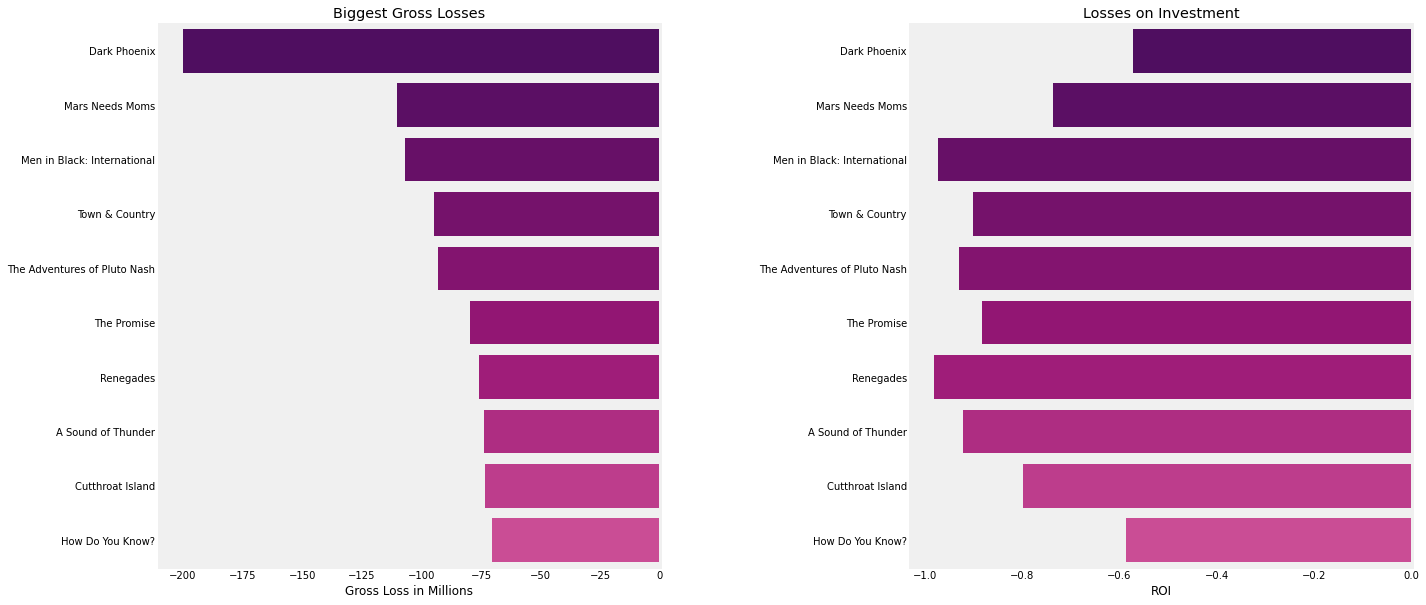

In [154]:
# Plotting worst financial movies
ten_worst = df.sort_values(by="gross_profit", ascending=True)[:10]

# Setting color, figsize
greens = sns.color_palette("RdPu_r", 25)
fig, ax = plt.subplots(ncols=2, figsize=(20,10), gridspec_kw={'wspace': .5})

# Plot gross profit
sns.barplot(y='movie', x='gross_profit', data=ten_worst, ax=ax[0], palette=greens)
ax[0].set_xlabel("Gross Loss in Millions")
ax[0].set_ylabel("")
ax[0].set_title("Biggest Gross Losses")
ax[0].grid(False)

# Plot loss on investment
ax[1].set_yticklabels("")
sns.barplot(y='movie', x='roi', data=ten_worst.sort_values(by='gross_profit', ascending=True), ax=ax[1], palette=greens)
ax[1].set_ylabel("")
ax[1].set_xlabel("ROI")
ax[1].set_title("Losses on Investment")
plt.grid(False);


In [155]:
# Display mean and median profits
print(f"""Mean/Median Profits (Millions): 
100M+   | Mean:{round(np.mean(hundred['gross_profit']), 2)}  | Median: {round(np.median(hundred['gross_profit']), 2)}
42M-100M| Mean:{round(np.mean(forty['gross_profit']), 2)}  | Median: {round(np.median(forty['gross_profit']), 2)}
6M-42M  | Mean:{round(np.mean(inner['gross_profit']), 2)}   | Median: {round(np.median(inner['gross_profit']), 2)}
<6M     | Mean:{round(np.mean(bottom['gross_profit']), 2)}   | Median: {round(np.median(bottom['gross_profit']), 2)}
""")

# Display mean and median ROI's
print(f"""Mean/Median ROI's: 
100M+    | Mean:{round(np.mean(hundred['roi']), 2)}    | Median: {round(np.median(hundred['roi']), 2)}
42M-100M | Mean:{round(np.mean(forty['roi']), 2)}   | Median: {round(np.median(forty['roi']), 2)}
6M-42M   | Mean:{round(np.mean(inner['roi']), 2)}   | Median: {round(np.median(inner['roi']), 2)}
<6M      | Mean:{round(np.mean(bottom['roi']), 2)}   | Median: {round(np.median(bottom['roi']), 2)}
""")

# Percentage of movies that lose money at each of the 4 budget tiers
perc_loss_Hplus = len(hundred.loc[hundred['gross_profit'] < 0]) / len(hundred)
perc_loss_FtH = len(forty.loc[forty['gross_profit'] < 0]) / len(forty)
perc_loss_mid = len(inner.loc[inner['gross_profit'] < 0]) / len(inner)
perc_loss_bot = len(bottom.loc[bottom['gross_profit'] < 0]) / len(bottom)

# Display profitablity information
print(f"""PROFITABILITY RATES: 
100M+    | {round(100 * (1-perc_loss_Hplus), 2)}%
42M-100M | {round(100 * (1-perc_loss_FtH), 2)}%
6M-42M   | {round(100 * (1-perc_loss_mid), 2)}%
<6M      | {round(100 * (1-perc_loss_bot), 2)}%""")

print("Maximum loss:", hundred['gross_profit'].min(), hundred.loc[
    hundred['gross_profit'].idxmin()]['movie'])

Mean/Median Profits (Millions): 
100M+   | Mean:357.32  | Median: 268.9
42M-100M| Mean:102.68  | Median: 63.67
6M-42M  | Mean:37.87   | Median: 12.85
<6M     | Mean:12.53   | Median: 1.21

Mean/Median ROI's: 
100M+    | Mean:2.2    | Median: 1.83
42M-100M | Mean:1.54   | Median: 0.95
6M-42M   | Mean:2.06   | Median: 0.72
<6M      | Mean:10.6   | Median: 0.9

PROFITABILITY RATES: 
100M+    | 93.37%
42M-100M | 74.38%
6M-42M   | 64.66%
<6M      | 61.79%
Maximum loss: -200.238 Dark Phoenix


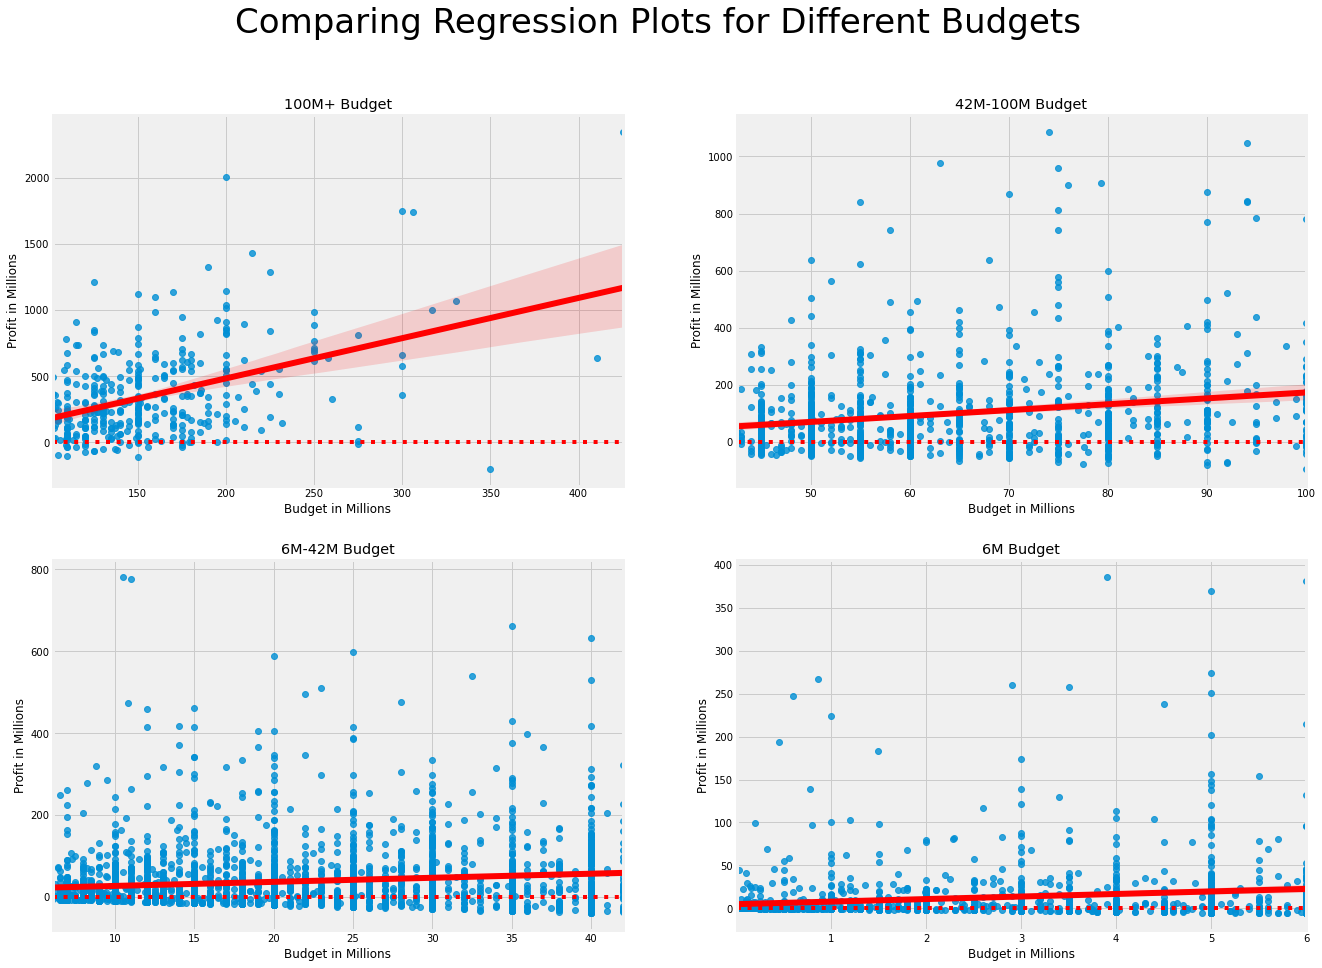

In [156]:
# Create a plot to show the regression charts of all 4 budget groups 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

sns.regplot(x="production_budget", y= "gross_profit", data=hundred, line_kws={"color": "red"}, ax=ax[0][0])
ax[0][0].axhline(y=0, color='red', linestyle='dotted')
ax[0][0].set_ylabel("Profit in Millions")
ax[0][0].set_xlabel("Budget in Millions")
ax[0][0].set_title("100M+ Budget")

sns.regplot(x="production_budget", y= "gross_profit", data=forty, line_kws={"color": "red"}, ax=ax[0][1])
ax[0][1].axhline(y=0, color='red', linestyle='dotted')
ax[0][1].set_ylabel("Profit in Millions")
ax[0][1].set_xlabel("Budget in Millions")
ax[0][1].set_title("42M-100M Budget")

sns.regplot(x="production_budget", y= "gross_profit", data=inner, line_kws={"color": "red"}, ax=ax[1][0])
ax[1][0].axhline(y=0, color='red', linestyle='dotted')
ax[1][0].set_ylabel("Profit in Millions")
ax[1][0].set_xlabel("Budget in Millions")
ax[1][0].set_title("6M-42M Budget")

sns.regplot(x="production_budget", y= "gross_profit", data=bottom, line_kws={"color": "red"}, ax=ax[1][1])
ax[1][1].axhline(y=0, color='red', linestyle='dotted')
ax[1][1].set_ylabel("Profit in Millions")
ax[1][1].set_xlabel("Budget in Millions")
ax[1][1].set_title("6M Budget")

plt.suptitle("Comparing Regression Plots for Different Budgets", fontsize=34);

## Supplimentary data will be used to access studio related information

In [157]:
bom_gross_df = pd.read_csv('../zippedData/bom.movie_gross.csv.gz')
bom_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [158]:
# Matching data by movie title and budget
studio_count = hundred.loc[hundred['movie'].isin(bom_gross_df['title'])]
studio_count.shape

(173, 12)

In [159]:
# Verify data
studio_count.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_profit,movie_year,date_time,roi,two_x,quartile
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,635.064,2011,2011-05-20,1.546673,1,Top 25
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014,1072.414,2015,2015-05-01,3.243842,1,Top 25


In [160]:
# Count the number of unique studios at the top budget level
studio_look = bom_gross_df.loc[bom_gross_df['title'].isin(hundred['movie'])]
studio_look['studio'].value_counts(normalize=True)[:6]

BV      0.254335
Fox     0.173410
WB      0.161850
Par.    0.115607
Uni.    0.098266
Sony    0.063584
Name: studio, dtype: float64

In [161]:
studio_look['studio'].unique()

array(['BV', 'WB', 'P/DW', 'Par.', 'Fox', 'Uni.', 'Sony', 'WB (NL)',
       'LGF', 'TriS', 'LG/S', 'STX'], dtype=object)

In [162]:
# Consolidate redundant studio names
studio_look['studio'] = studio_look["studio"].apply(lambda x: "WB" if "WB" in x else x)
studio_look['studio'] = studio_look["studio"].apply(lambda x: "LG" if "LG" in x else x)


<ipython-input-162-005b79a8904e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  studio_look['studio'] = studio_look["studio"].apply(lambda x: "WB" if "WB" in x else x)
<ipython-input-162-005b79a8904e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  studio_look['studio'] = studio_look["studio"].apply(lambda x: "LG" if "LG" in x else x)


In [163]:
len(studio_look['studio'].unique())

10

### The following is a general investigation of various franchises:

In [164]:
batman = df[df["movie"].str.contains("Batman")]
batman['roi'].min()

0.906544

In [165]:
batman['production_budget'].mean()

117.14285714285714

In [166]:
shrek = df[df["movie"].str.contains("Shrek")]

In [167]:
shrek['roi'].mean()

7.212802587932902

In [168]:
shrek['production_budget'].mean()

111.25

In [169]:
mtp = df[(df["movie"].str.contains("Meet the")) & (df["id"].isin([43, 86]))]
mtp['roi'].mean(), mtp['production_budget'].mean()

(6.3085969696969695, 57.5)

In [170]:
pp = df[df["movie"].str.contains("Pitch Perfect")]
pp['roi'].mean(), pp['production_budget'].mean()

(5.95722925400045, 30.333333333333332)

In [171]:
paranormal = df[df["movie"].str.contains("Paranormal Activity")]
paranormal['roi'].mean(), paranormal['production_budget'].mean()

(96.77282407407408, 4.741666666666666)

In [172]:
saw = df[df["movie"].str.contains("Saw")]
saw['roi'].mean(), saw['production_budget'].mean()

(23.609798950287193, 9.285714285714286)

In [173]:
# Create df objects to evaluate studio counts
studio_look2 = bom_gross_df.loc[bom_gross_df['title'].isin(forty['movie'])]
studio_look3 = bom_gross_df.loc[bom_gross_df['title'].isin(inner['movie'])]
studio_look4 = bom_gross_df.loc[bom_gross_df['title'].isin(bottom['movie'])]

In [174]:
# Number of unique studios in different budget tiers
len(studio_look['studio'].unique()), len(studio_look2['studio'].unique()), len(studio_look3['studio'].unique()), len(studio_look4['studio'].unique())

(10, 33, 75, 59)

# Best performers at top budget tier

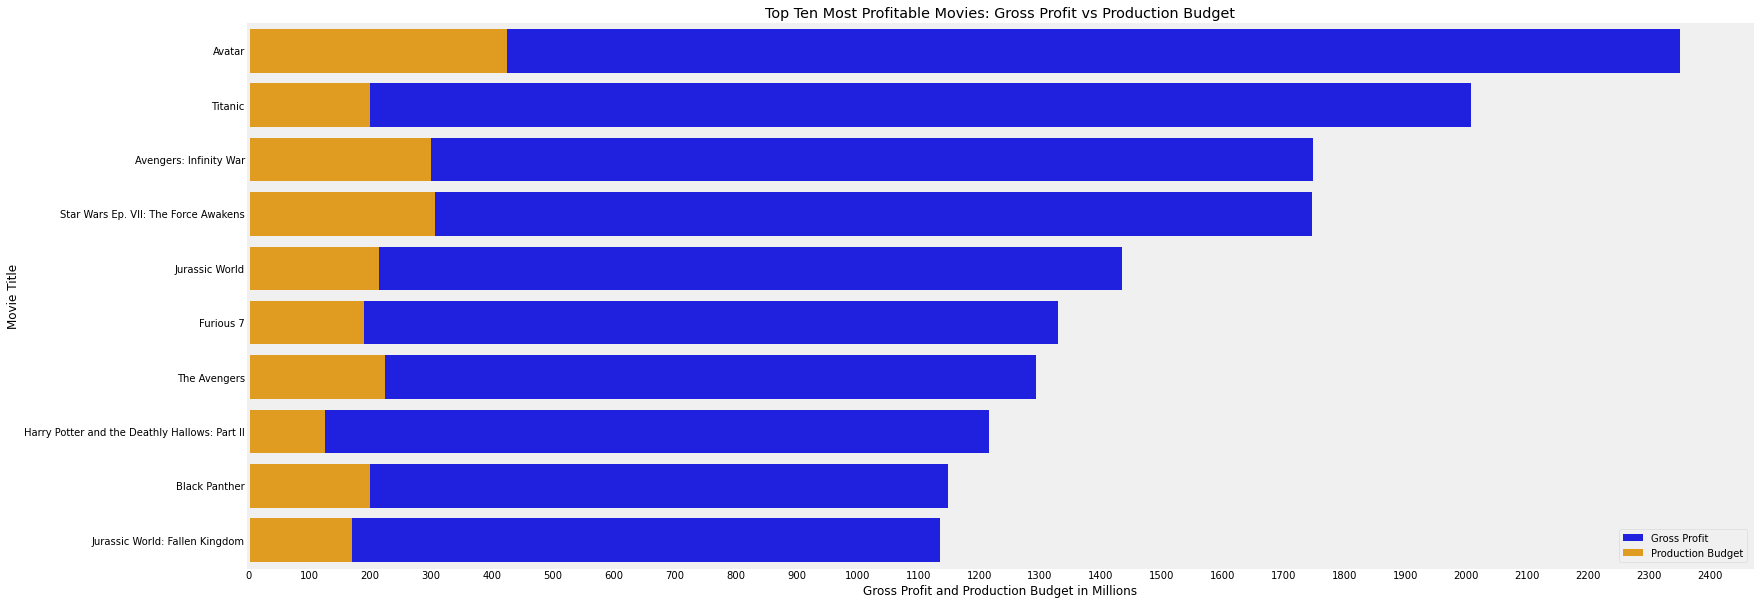

In [175]:
# Plotting Profit and Budget for 100M+
fig, ax = plt.subplots(figsize=(24,10))

# Creates new df object to assist with plotting 
top_movies = hundred.sort_values(by='gross_profit', ascending=False)[:10]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title")
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 2420, 100))
plt.grid(False);

# Best performers at 2nd budget tier

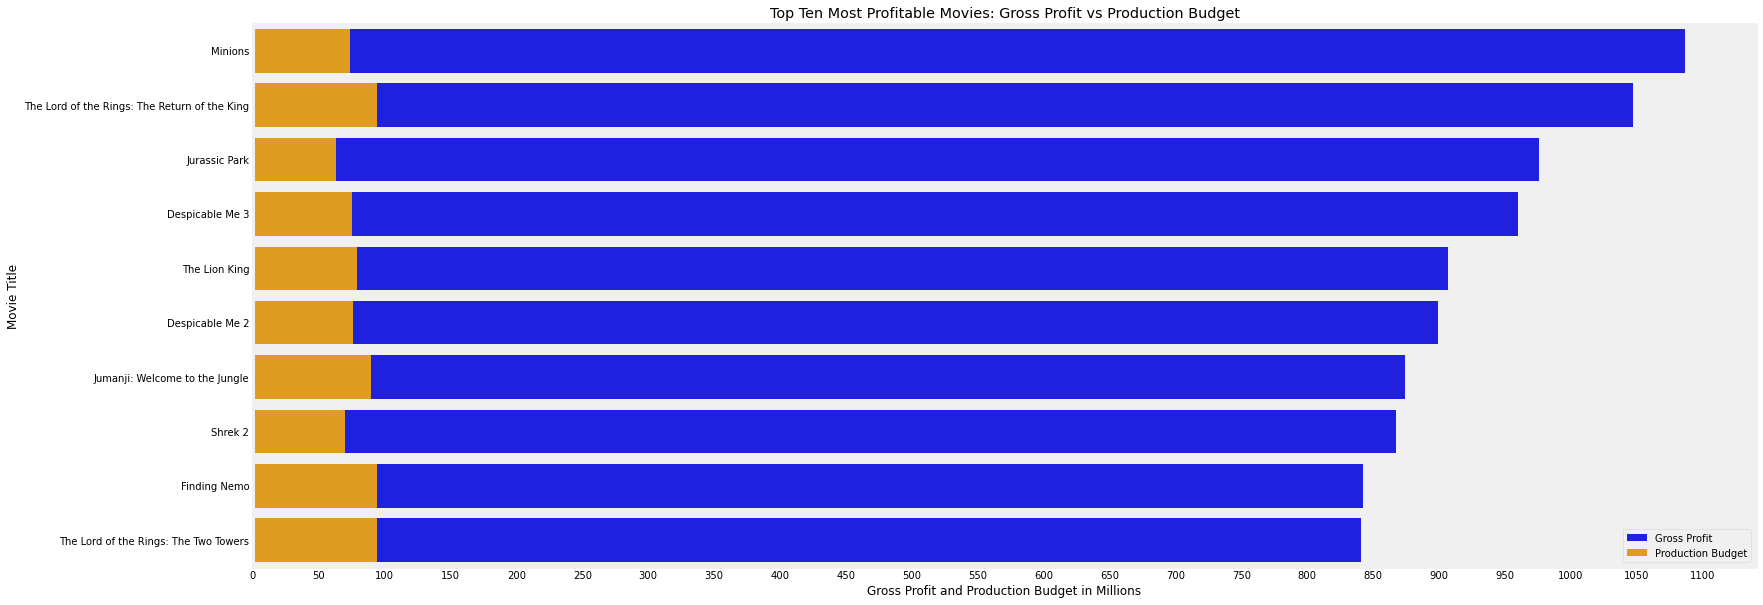

In [176]:
# Plotting Profit and Budget
fig, ax = plt.subplots(figsize=(24,10))
# Creates new df object to assist with plotting 
top_movies = forty.sort_values(by='gross_profit', ascending=False)[:10]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title")
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 1150, 50))
plt.grid(False);

# Best performers at 3rd budget tier

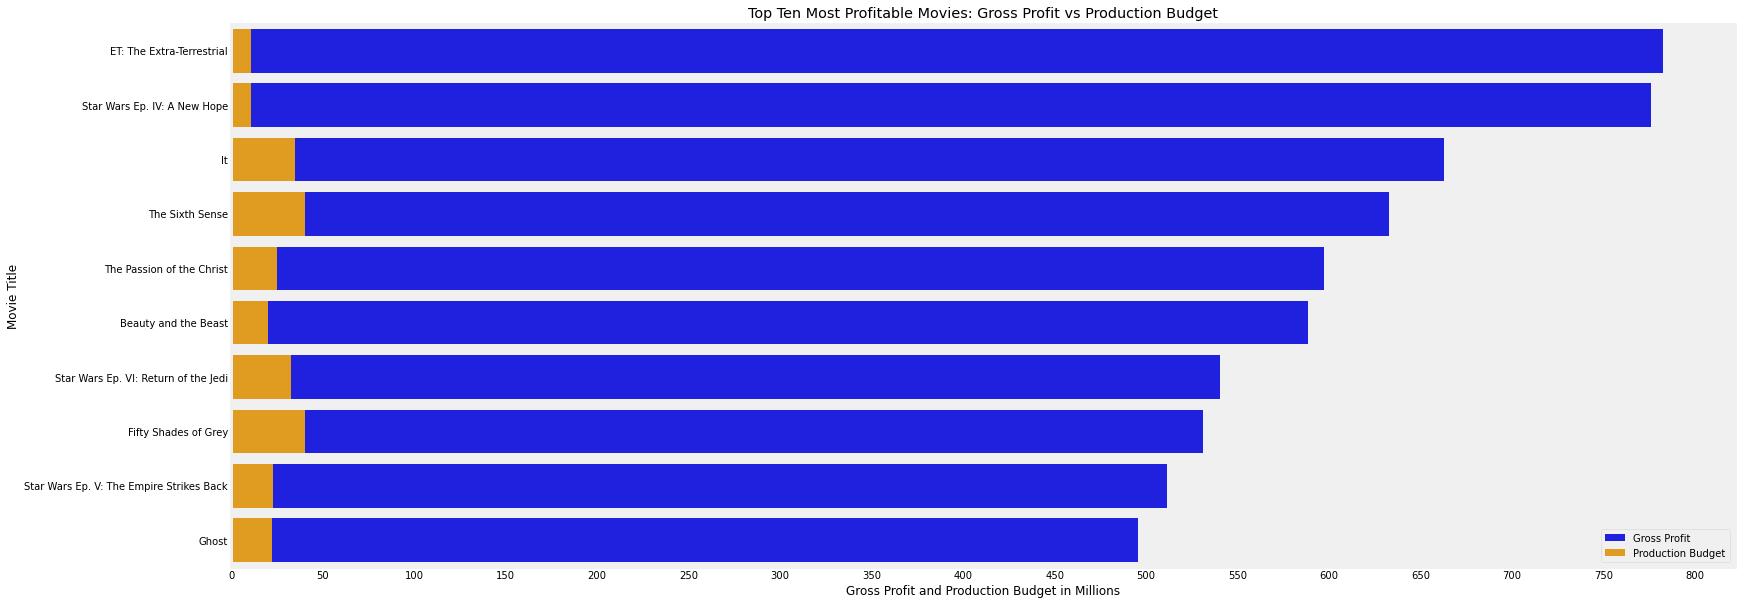

In [177]:
# Plotting Profit and Budget
fig, ax = plt.subplots(figsize=(24,10))
# Creates new df object to assist with plotting 
top_movies = inner.sort_values(by='gross_profit', ascending=False)[:10]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title")
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 850, 50))
plt.grid(False);

# Best performers at bottom budget tier

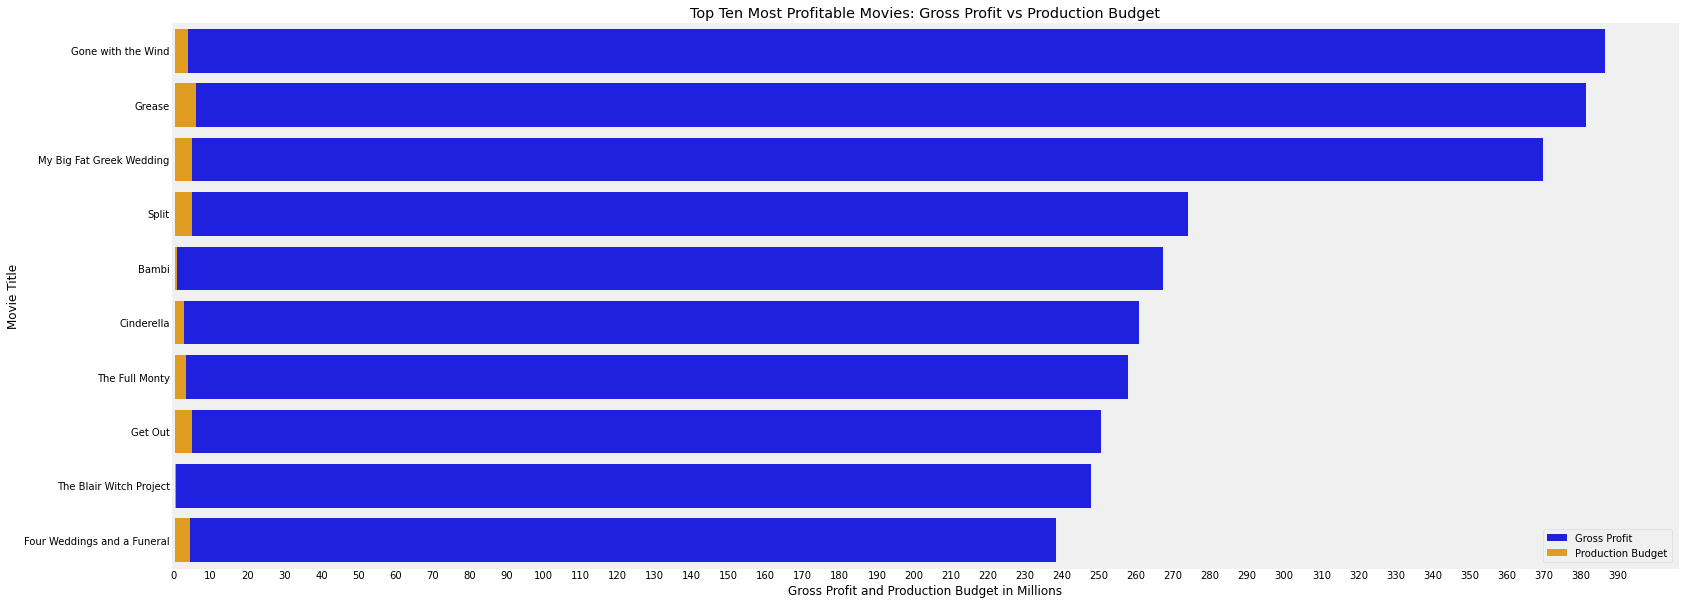

In [178]:
# Plotting Profit and Budget
fig, ax = plt.subplots(figsize=(24,10))

# Creates new df object to assist with plotting 
top_movies = bottom.sort_values(by='gross_profit', ascending=False)[:10]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title")
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 400, 10))
plt.grid(False);

# Pairplots for every budget group

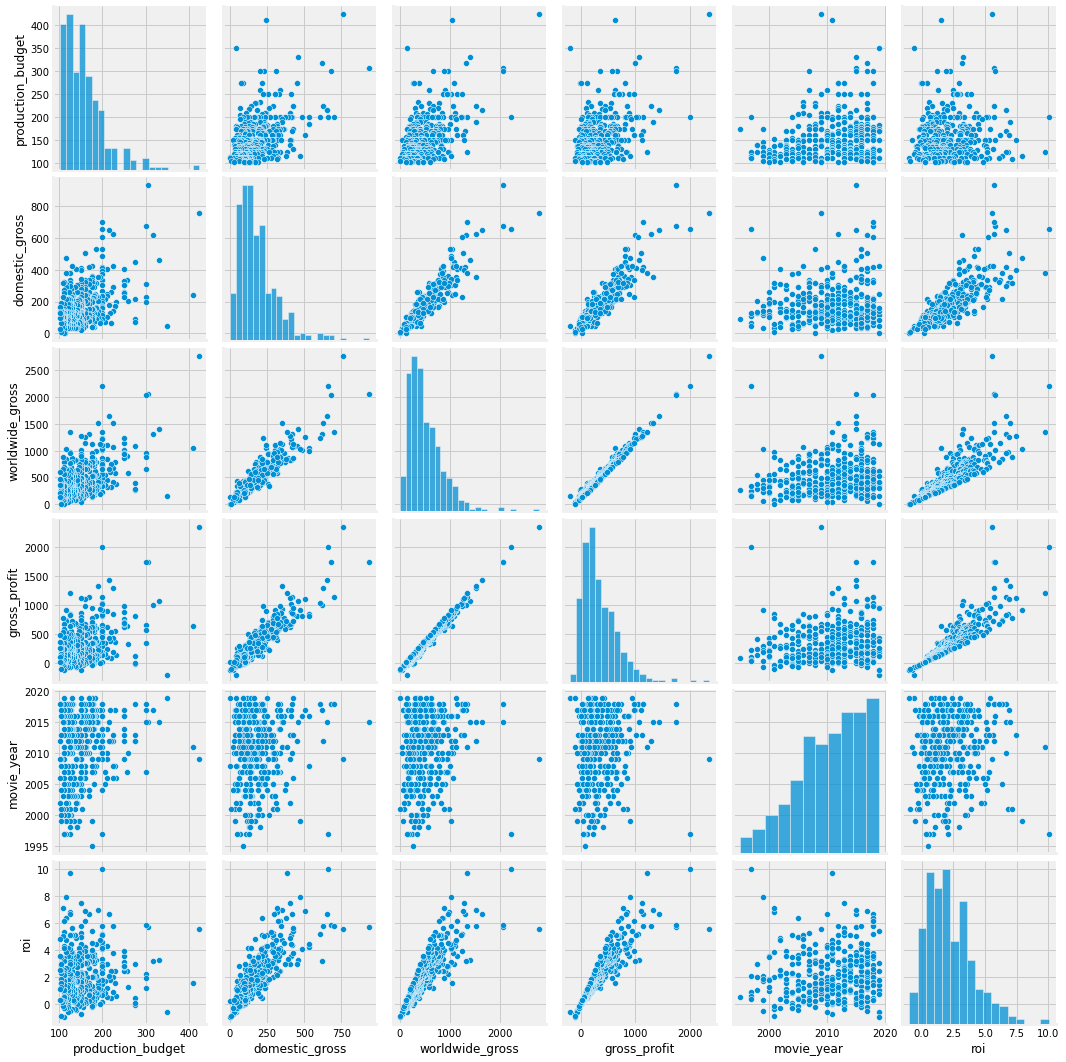

In [179]:
# 100M+
sns.pairplot(hundred.drop(columns=['id', 'two_x']));

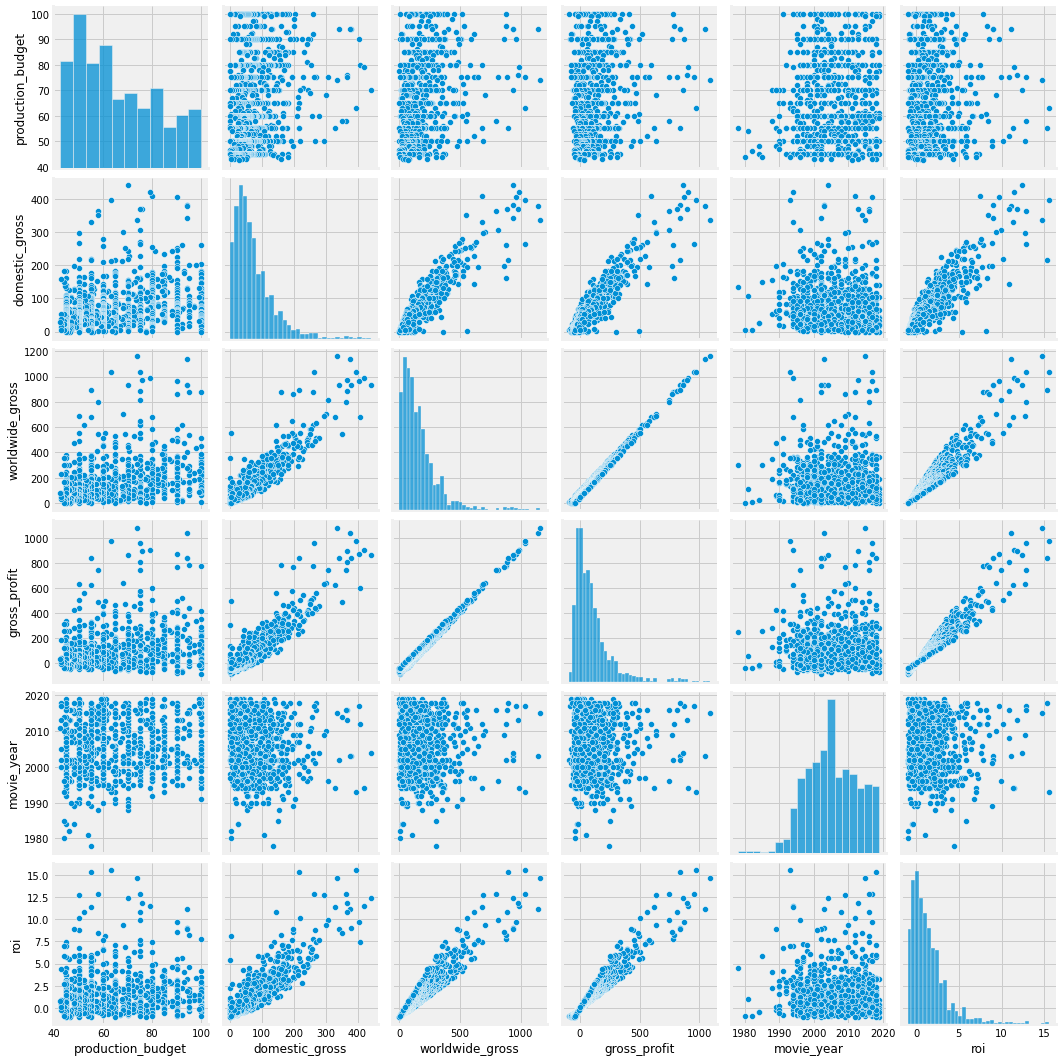

In [180]:
# 42M-100M
sns.pairplot(forty.drop(columns=['id', 'two_x']));

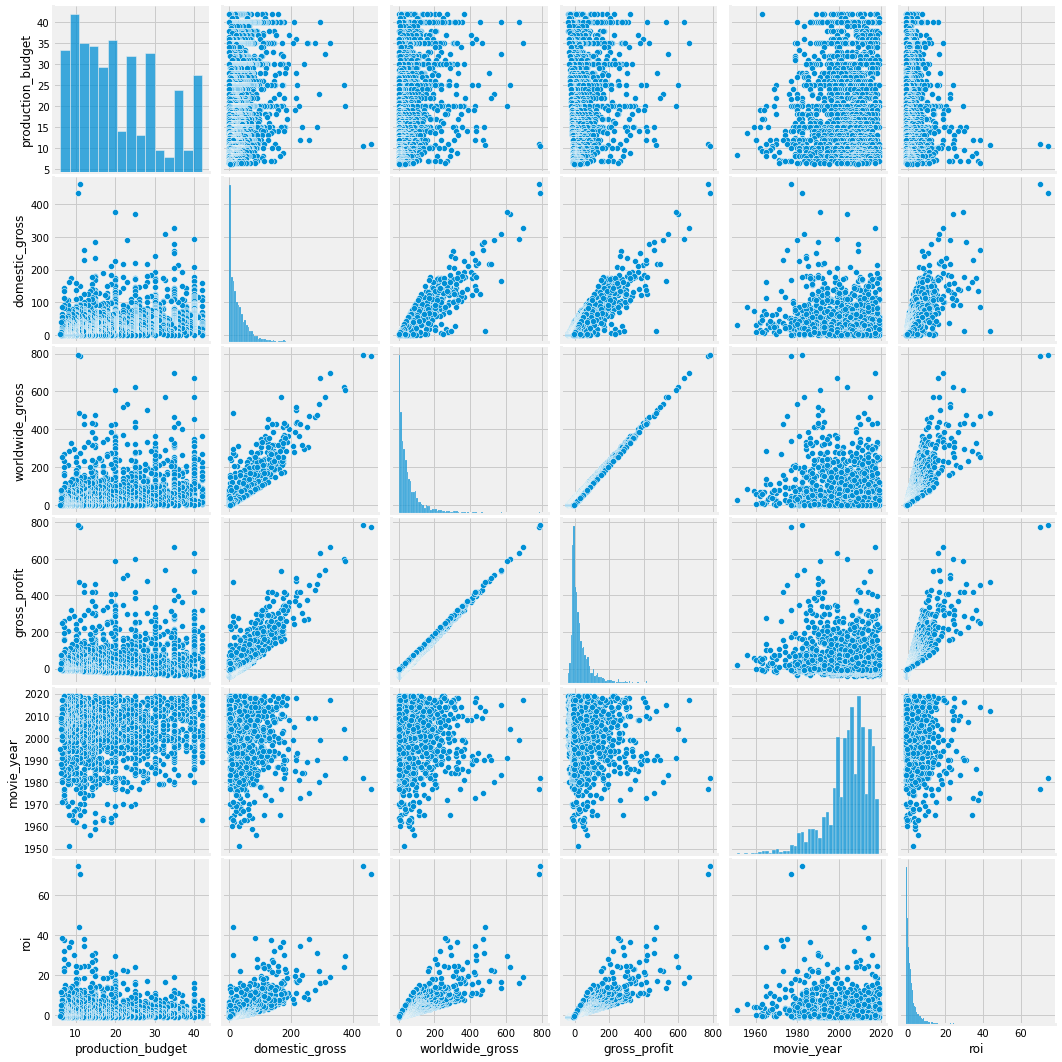

In [181]:
# 6M-42M
sns.pairplot(inner.drop(columns=['id', 'two_x']));

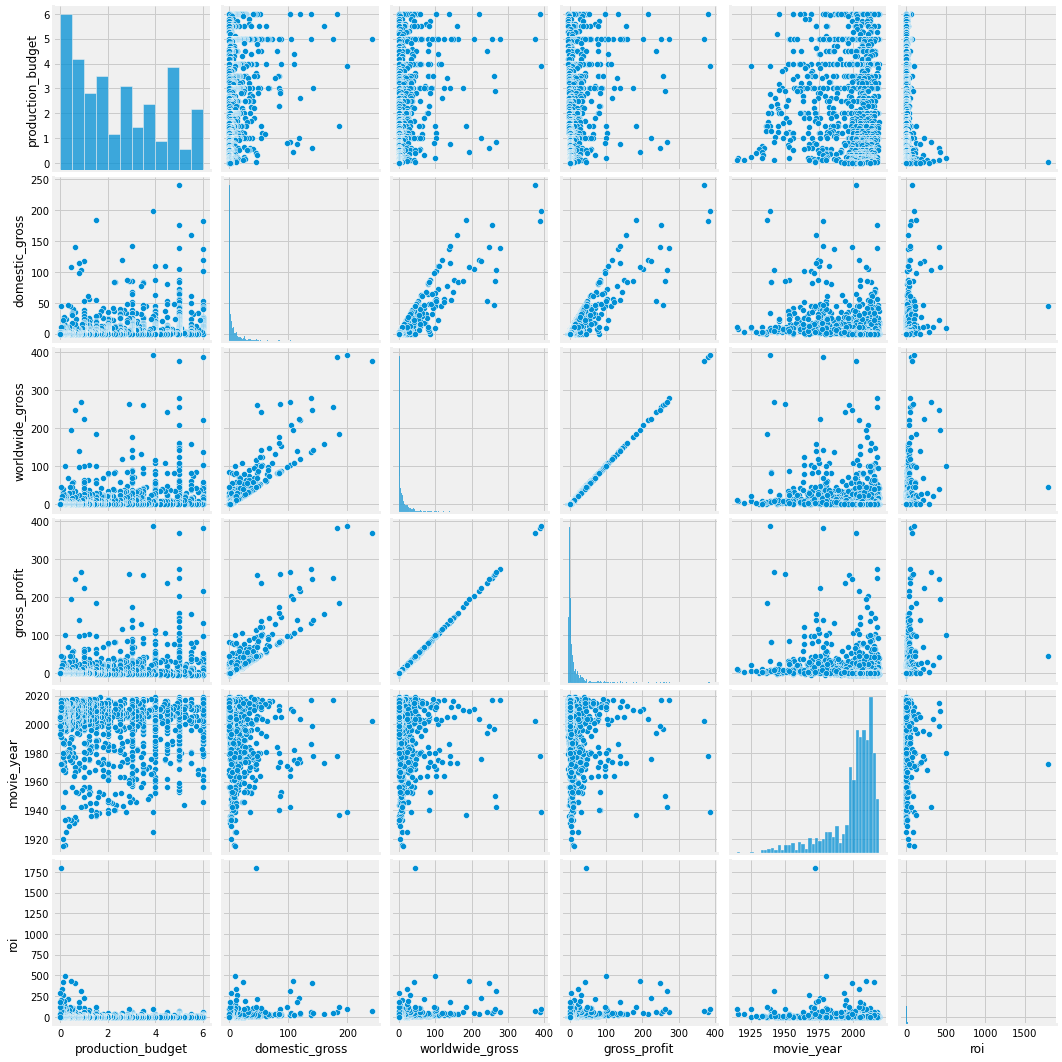

In [182]:
# 6M or less
sns.pairplot(bottom.drop(columns=['id', 'two_x']));

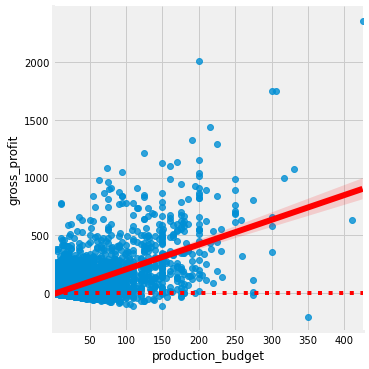

In [183]:
# Reg plot for ALL movies profit/budget
sns.lmplot(y='gross_profit' , x='production_budget' , data=df, line_kws={"color": "red"})
plt.axhline(y=0, color='red', linestyle='dotted');

# Modeling upper tier of budgets

In [184]:
# Modeling ROI by budget
exog = sm.add_constant(hundred['production_budget'])  # independent
endog = hundred['roi']  # dependent
lin_reg_model = sm.OLS(endog, exog).fit() 

In [185]:
lin_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.952
Date:                Thu, 14 Sep 2023   Prob (F-statistic):             0.0866
Time:                        21:51:11   Log-Likelihood:                -732.50
No. Observations:                 362   AIC:                             1469.
Df Residuals:                     360   BIC:                             1477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.6574      0.332      4.988      0.000       1.004       2.311
production_budget     0.0034      0.002      1.718      0.087      -0.000       0.007
==============================================================================
Omnibus:                       59.598   Durbin-Watson:                   1.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.889
Skew:                           1.022   Prob(JB):                     1.84e-20
Kurtosis:                       4.359   Cond. No.                         571.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

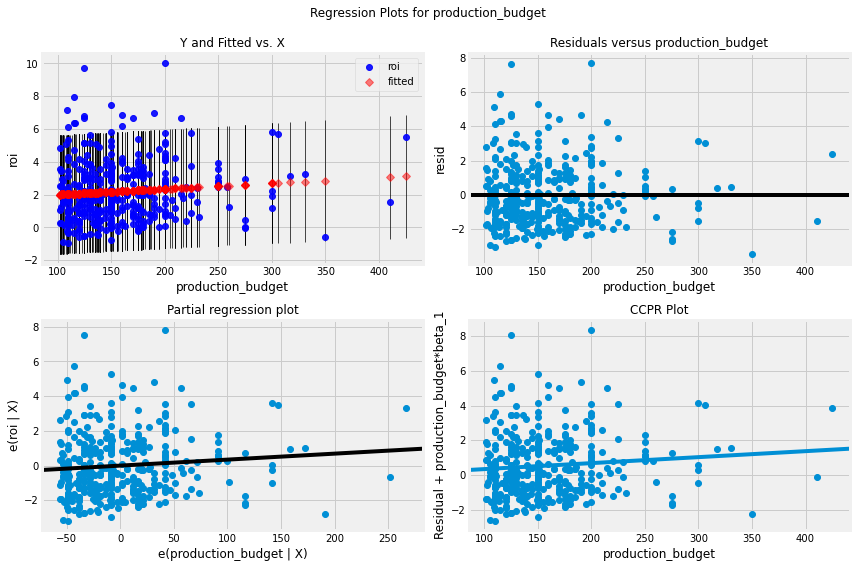

In [186]:
# ROI as a function of production budget, for every million spent, roi increases by .0065

sm.graphics.plot_regress_exog(lin_reg_model, 'production_budget', fig=plt.figure(figsize=(12, 8)));

### Roi, even at the highest budget, is not highly correlative, let's examine profits
### 100M+

In [187]:
# Modeling Budget and Profit for most expensive group
X_c = sm.add_constant(hundred['production_budget']) # independent
y = hundred['gross_profit'] # dependent
model = sm.OLS(endog=y, exog=X_c).fit()

In [188]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_profit   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     83.73
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           4.31e-18
Time:                        21:51:14   Log-Likelihood:                -2583.0
No. Observations:                 362   AIC:                             5170.
Df Residuals:                     360   BIC:                             5178.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -125.5910     55.151     -2.277      0.023    -234.050     -17.132
production_budget     3.0463      0.333      9.150      0.000       2.392       3.701
==============================================================================
Omnibus:                       71.120   Durbin-Watson:                   1.158
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.527
Skew:                           0.958   Prob(JB):                     1.26e-38
Kurtosis:                       5.811   Cond. No.                         571.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

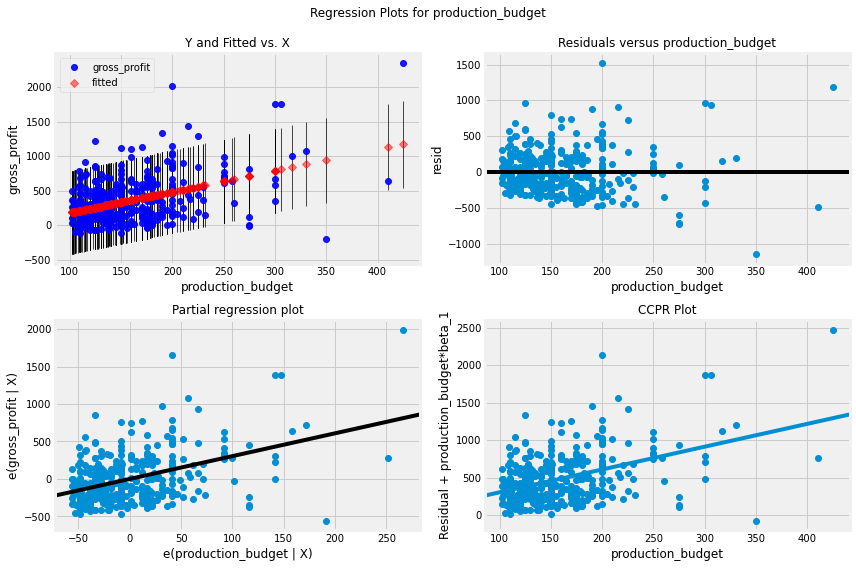

In [189]:
sm.graphics.plot_regress_exog(model, 'production_budget', fig=plt.figure(figsize=(12, 8)));

### 42-100M

In [190]:
# Modeling Budget and Profit for most expensive group
X_c = sm.add_constant(forty['production_budget']) # independent
y = forty['gross_profit'] # dependent
model = sm.OLS(endog=y, exog=X_c).fit()

In [191]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_profit   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     43.53
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           6.88e-11
Time:                        21:51:17   Log-Likelihood:                -6258.7
No. Observations:                 968   AIC:                         1.252e+04
Df Residuals:                     966   BIC:                         1.253e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -32.1803     21.044     -1.529      0.127     -73.478       9.117
production_budget     2.0601      0.312      6.597      0.000       1.447       2.673
==============================================================================
Omnibus:                      537.865   Durbin-Watson:                   0.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4144.776
Skew:                           2.479   Prob(JB):                         0.00
Kurtosis:                      11.842   Cond. No.                         284.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

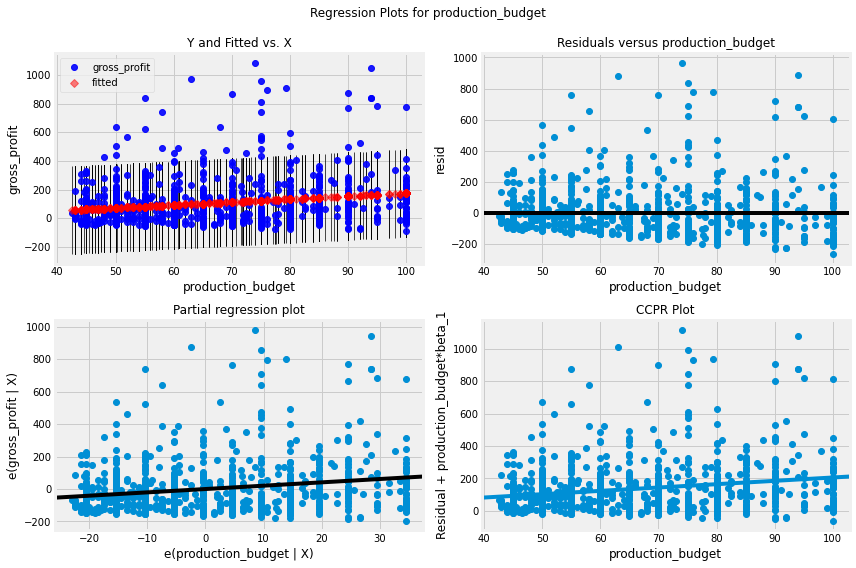

In [192]:
sm.graphics.plot_regress_exog(model, 'production_budget', fig=plt.figure(figsize=(12, 8)));

### 6M-42M

In [193]:
# Modeling Budget and Profit for most expensive group
X_c = sm.add_constant(inner['production_budget']) # independent
y = inner['gross_profit'] # dependent
model = sm.OLS(endog=y, exog=X_c).fit()

In [194]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_profit   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     46.68
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           1.03e-11
Time:                        21:51:21   Log-Likelihood:                -15624.
No. Observations:                2714   AIC:                         3.125e+04
Df Residuals:                    2712   BIC:                         3.126e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                17.3535      3.343      5.191      0.000      10.799      23.908
production_budget     0.9928      0.145      6.832      0.000       0.708       1.278
==============================================================================
Omnibus:                     2042.462   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41888.938
Skew:                           3.424   Prob(JB):                         0.00
Kurtosis:                      20.987   Cond. No.                         52.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

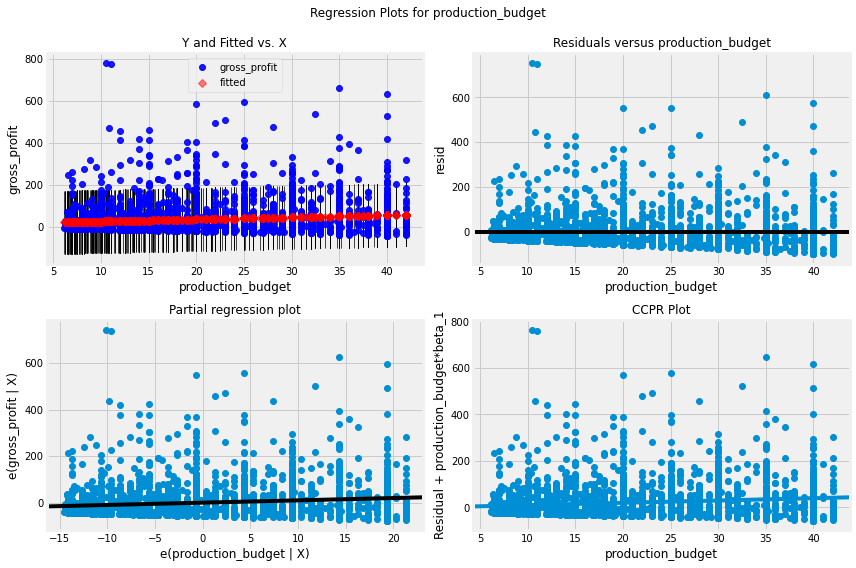

In [195]:
sm.graphics.plot_regress_exog(model, 'production_budget', fig=plt.figure(figsize=(12, 8)));

### 6M or less

In [196]:
# Modeling Budget and Profit for most expensive group
X_c = sm.add_constant(bottom['production_budget']) # independent
y = bottom['gross_profit'] # dependent
model = sm.OLS(endog=y, exog=X_c).fit()

In [197]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_profit   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     34.54
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           5.25e-09
Time:                        21:51:24   Log-Likelihood:                -6782.3
No. Observations:                1366   AIC:                         1.357e+04
Df Residuals:                    1364   BIC:                         1.358e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.8570      1.608      3.021      0.003       1.703       8.011
production_budget     2.9640      0.504      5.877      0.000       1.975       3.953
==============================================================================
Omnibus:                     1508.357   Durbin-Watson:                   1.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101352.865
Skew:                           5.544   Prob(JB):                         0.00
Kurtosis:                      43.716   Cond. No.                         5.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

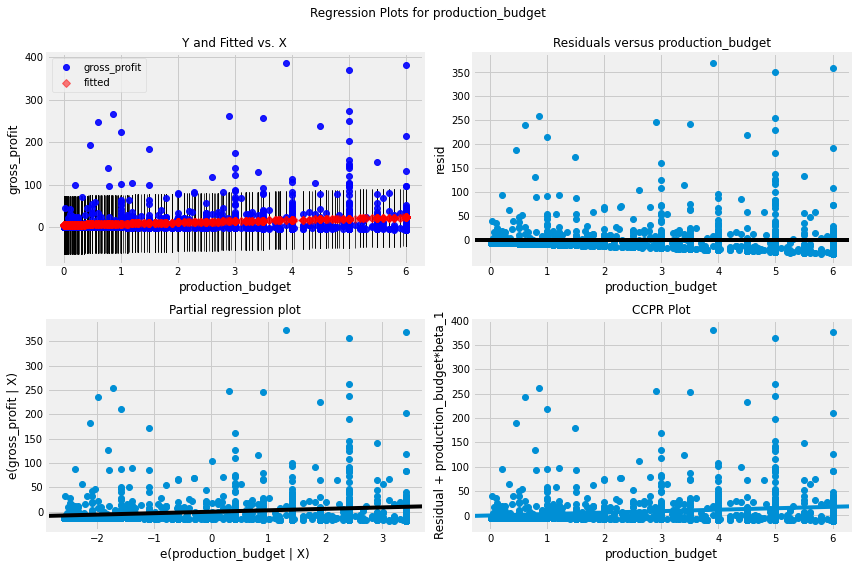

In [198]:
sm.graphics.plot_regress_exog(model, 'production_budget', fig=plt.figure(figsize=(12, 8)));

# Removing the outlier most profitable films

In [199]:
no_outliers = hundred.loc[hundred['gross_profit'] < 1000, 'gross_profit']
X_c = sm.add_constant(hundred.loc[hundred['gross_profit'] < 1000, 'production_budget'])
y = no_outliers
model_wo_outliers = sm.OLS(endog=y, exog=X_c).fit()

In [200]:
no_outliers.describe()

count    347.000000
mean     312.931902
std      254.623409
min     -200.238000
25%      119.587000
50%      252.989000
75%      492.782500
max      999.722000
Name: gross_profit, dtype: float64

# Model for films costing more than 100M and making less than 1B

In [201]:
model_wo_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_profit   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     33.91
Date:                Thu, 14 Sep 2023   Prob (F-statistic):           1.32e-08
Time:                        21:51:29   Log-Likelihood:                -2397.9
No. Observations:                 347   AIC:                             4800.
Df Residuals:                     345   BIC:                             4808.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                44.6457     47.888      0.932      0.352     -49.543     138.834
production_budget     1.7243      0.296      5.823      0.000       1.142       2.307
==============================================================================
Omnibus:                        8.841   Durbin-Watson:                   1.127
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.144
Skew:                           0.396   Prob(JB):                       0.0103
Kurtosis:                       2.935   Cond. No.                         593.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

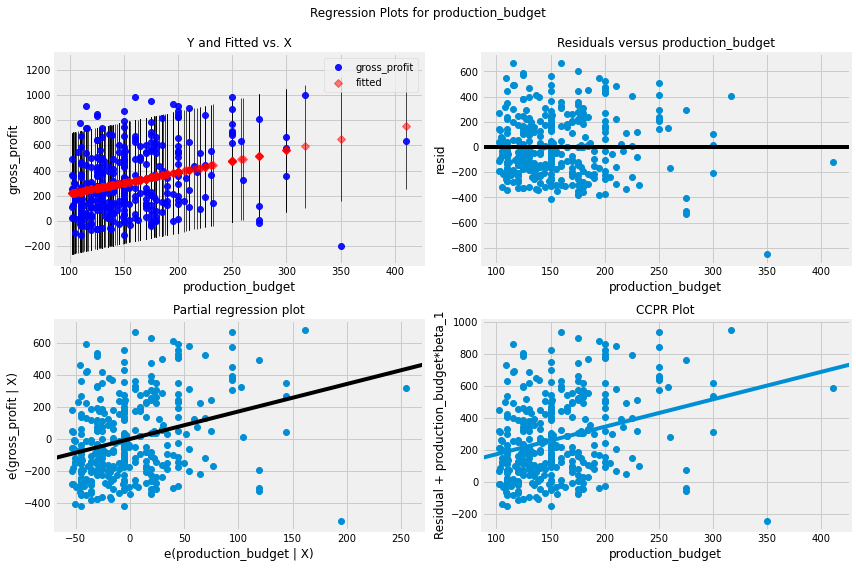

In [202]:
sm.graphics.plot_regress_exog(model_wo_outliers, 'production_budget', fig=plt.figure(figsize=(12, 8)));

In [203]:
# Same plot as above except plotting ROI/budget

no_outliers_roi = hundred.loc[hundred['gross_profit'] < 1000, 'roi']
X_c_roi = sm.add_constant(hundred.loc[hundred['gross_profit'] < 1000, 'production_budget'])
y = no_outliers_roi
roi_model_wo_outliers = sm.OLS(endog=y, exog=X_c_roi).fit()
roi_model_wo_outliers.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1484
Date:                Thu, 14 Sep 2023   Prob (F-statistic):              0.700
Time:                        21:51:30   Log-Likelihood:                -657.75
No. Observations:                 347   AIC:                             1320.
Df Residuals:                     345   BIC:                             1327.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1385      0.318      6.727      0.000       1.513       2.764
production_budget    -0.0008      0.002     -0.385      0.700      -0.005       0.003
==============================================================================
Omnibus:                       26.233   Durbin-Watson:                   1.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.020
Skew:                           0.705   Prob(JB):                     3.03e-07
Kurtosis:                       3.295   Cond. No.                         593.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interesting negative trajectory, possibly impacted by negative outliers as well, but intercept > 2 

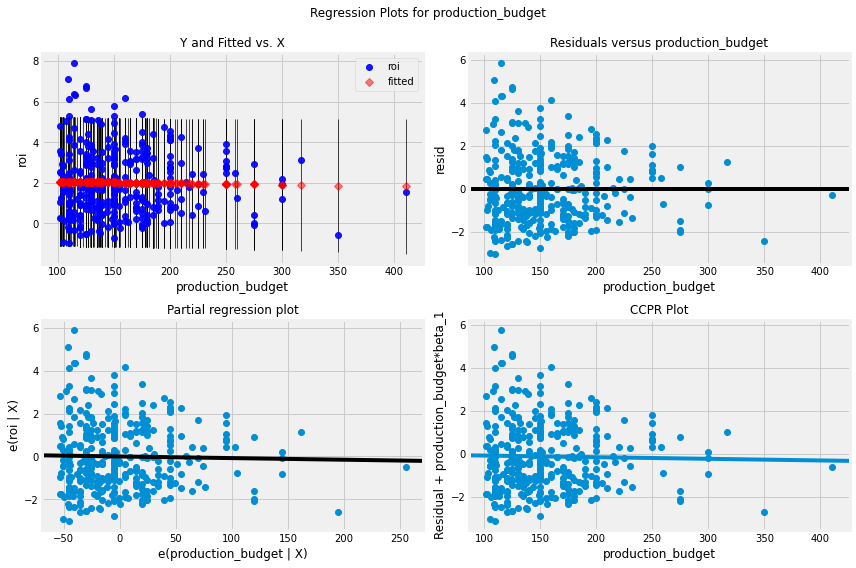

In [204]:
sm.graphics.plot_regress_exog(roi_model_wo_outliers, 'production_budget', fig=plt.figure(figsize=(12, 8)));

# Identifying top 10% of ROI's: top quartile, inner quartile, bottom quartile

In [205]:
top_ten_perc_exp = df.loc[(df['production_budget'] >= 42.000000) & (df['roi'] > df['roi'].quantile(.9))]
top_ten_perc_exp.shape

(37, 12)

In [206]:

top_ten_perc_mid = inner.loc[inner['roi'] > inner['roi'].quantile(.9)]
top_ten_perc_mid.shape

(272, 12)

In [207]:
top_ten_perc_bot = bottom.loc[bottom['roi'] > bottom['roi'].quantile(.9)]
top_ten_perc_bot.shape

(137, 12)

# Now, filter for movies after the year 1996 (Titanic cutoff)

In [208]:
top_ten_perc_bot.describe()

,id,production_budget,domestic_gross,worldwide_gross,gross_profit,movie_year,roi,two_x
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.0
mean,51.912409,1.709314,44.108628,75.762467,74.053153,1990.094891,86.469037,1.0
std,27.501196,1.807042,48.813191,83.069206,81.824430,23.685092,171.484466,0.0
min,1.000000,0.001000,0.000000,0.181000,0.180000,1915.000000,17.776000,1.0
25%,26.000000,0.200000,7.719000,15.155000,14.905000,1976.000000,26.179143,1.0
50%,58.000000,1.000000,24.146000,46.123000,45.723000,1998.000000,39.598500,1.0
75%,75.000000,3.000000,65.206000,103.301000,100.759000,2007.000000,85.566667,1.0
max,100.000000,6.000000,241.438000,390.525000,386.625000,2018.000000,1799.000000,1.0


In [209]:
top_budget = top_ten_perc_exp.loc[top_ten_perc_exp['movie_year'] > 1996]
middle_budget = top_ten_perc_mid.loc[top_ten_perc_mid['movie_year'] > 1996]
bottom_budget = top_ten_perc_bot.loc[top_ten_perc_bot['movie_year'] > 1996]

In [210]:
top_budget.shape

(32, 12)

In [211]:
middle_budget.shape

(176, 12)

In [212]:
bottom_budget.shape

(75, 12)

In [213]:
top_budget.sort_values(by="movie").head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_profit,movie_year,date_time,roi,two_x,quartile
948,57,"Dec 25, 2014",American Sniper,58.0,350.126,547.326,489.326,2014,2014-12-25,8.436655,1,Top 25
975,84,"Nov 2, 2018",Bohemian Rhapsody,55.0,216.303,894.985,839.985,2018,2018-11-02,15.272455,1,Top 25
947,56,"Feb 12, 2016",Deadpool,58.0,363.071,801.026,743.026,2016,2016-02-12,12.810793,1,Top 25
617,22,"Jul 3, 2013",Despicable Me 2,76.0,368.065,975.217,899.217,2013,2013-07-03,11.831803,1,Top 25
625,30,"Jun 30, 2017",Despicable Me 3,75.0,264.624,1034.728,959.728,2017,2017-06-30,12.796373,1,Top 25


In [214]:
top_budget['roi'].describe()

count    32.000000
mean      9.693770
std       2.243795
min       7.248520
25%       7.767184
50%       8.952814
75%      10.916641
max      15.272455
Name: roi, dtype: float64

### This filter knocked the original Avatar out of the list, surprisingly

In [215]:
hundred.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,gross_profit,movie_year,date_time,roi,two_x,quartile
0,1,"Dec 18, 2009",Avatar,425.0,760.508,2776.345,2351.345,2009,2009-12-18,5.532576,1,Top 25
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,635.064,2011,2011-05-20,1.546673,1,Top 25


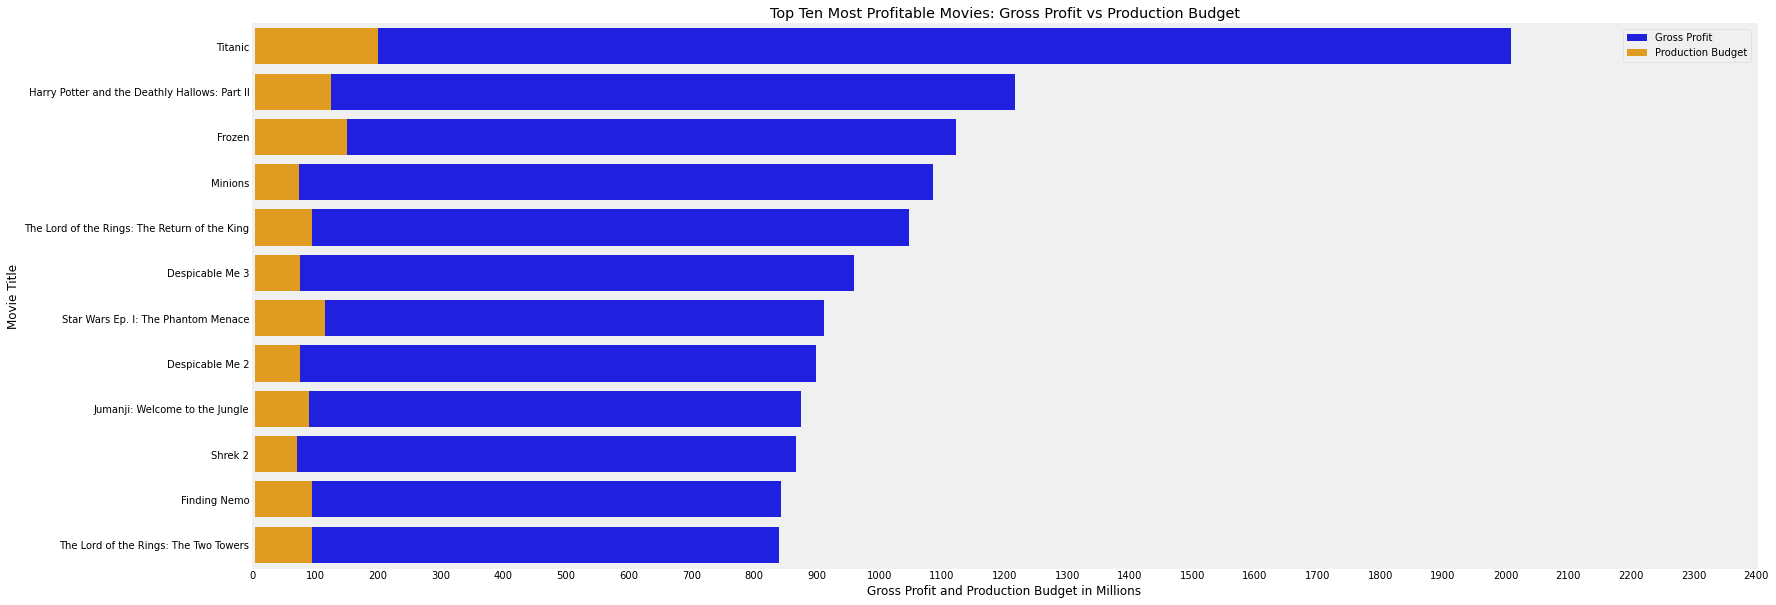

In [216]:
# Plotting Profit and Budget for this elite slice

fig, ax = plt.subplots(figsize=(24,10))
# Creates new df object to assist with plotting 
top_movies = top_budget.sort_values(by="gross_profit", ascending=False)[:12]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title")
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 2420, 100))
plt.grid(False);

### Inner quartile  (warning due to special chars in King's Speech)

/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


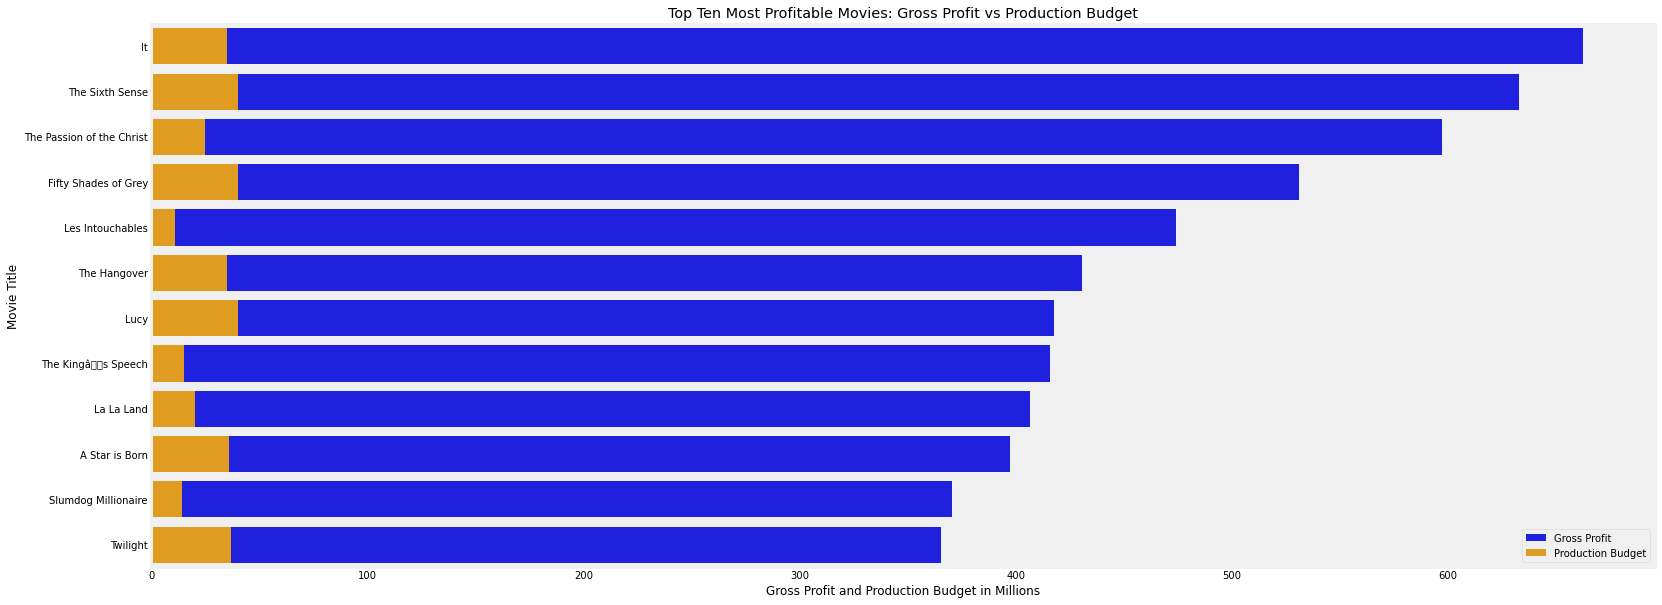

In [217]:
# Plotting Profit and Budget
fig, ax = plt.subplots(figsize=(24,10))

# Creates new df object to assist with plotting 
top_movies = middle_budget.sort_values(by="gross_profit", ascending=False)[:12]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title")
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 700, 100))
plt.grid(False);

### Bottom quartile

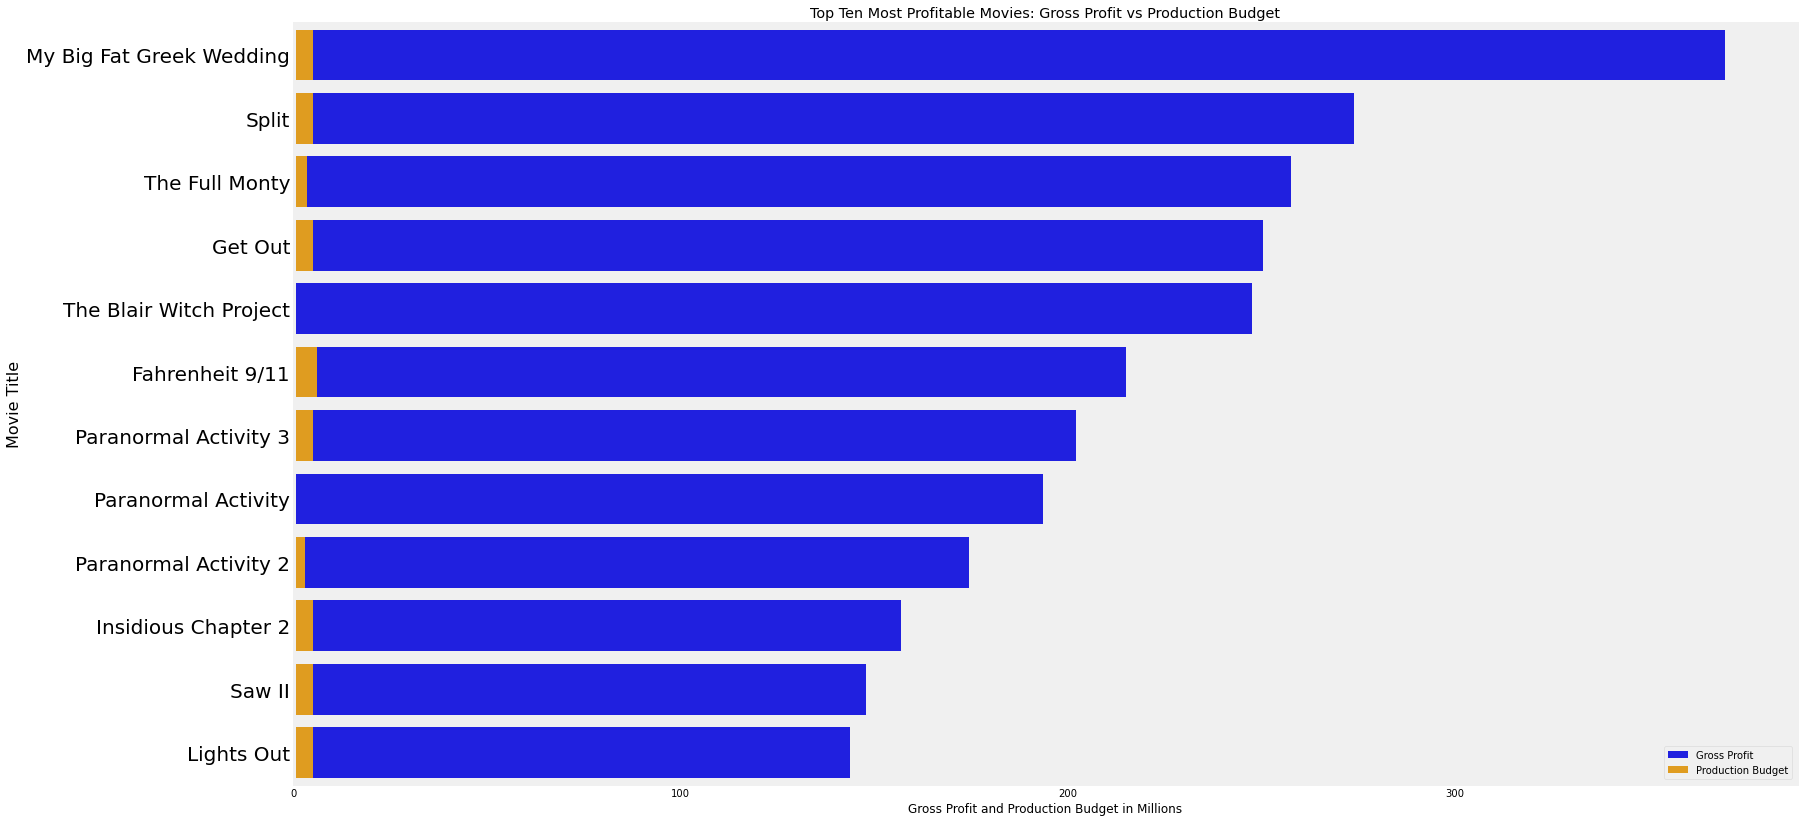

In [218]:
# Plotting Profit and Budget
fig, ax = plt.subplots(figsize=(24,14))
# Creates new df object to assist with plotting 
top_movies = bottom_budget.sort_values(by="gross_profit", ascending=False)[:12]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax, label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax, label='Production Budget')

ax.set_xlabel("Gross Profit and Production Budget in Millions")
ax.set_ylabel("Movie Title", fontsize=16)
ax.set_title("Top Ten Most Profitable Movies: Gross Profit vs Production Budget")
ax.legend()
plt.xticks(np.arange(0, 400, 100))
plt.tick_params(axis='y', labelsize=20)
plt.grid(False);

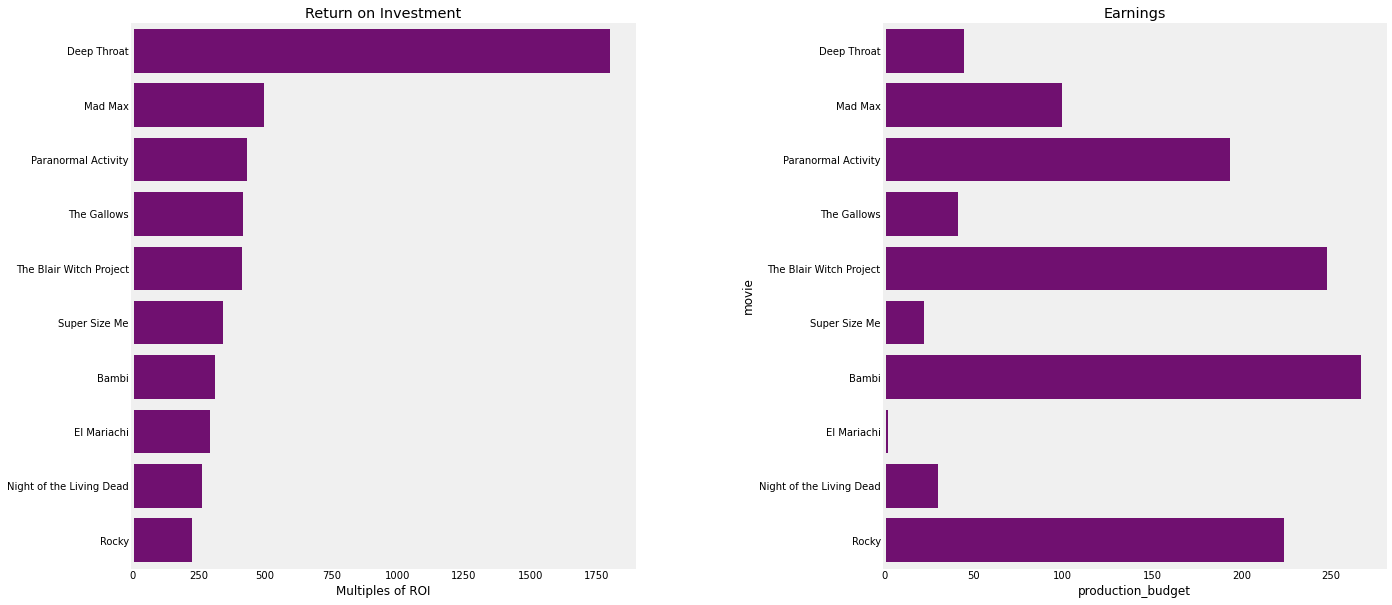

In [219]:
# Chart illustrating the top 10 ROI's for movies in our data
top_ten = df.sort_values(by='roi', ascending=False)[:10]
greens = sns.color_palette("PuBuGn_r", 25)
fig, ax = plt.subplots(ncols=2, figsize=(20,10), gridspec_kw={'wspace': .5})

# ROI
ax[0].set_yticklabels("")
sns.barplot(y='movie', x='roi', data=top_ten, ax=ax[0], color='purple')
ax[0].set_ylabel("")
ax[0].set_xlabel("Multiples of ROI")
ax[0].set_title("Return on Investment")
ax[0].grid(False)

# gross profit
sns.barplot(y='movie', x='gross_profit', data=top_ten, ax=ax[1], color='purple')
ax[1].set_xlabel("Gross Profit in Millions")
ax[1].set_ylabel("")
ax[1].set_title("Earnings")

# stack budget on top of gross earnings - its so small, it doesn't even show up, HUGE ROI's
sns.barplot(y='movie', x='production_budget', data= top_ten, ax=ax[1], color='yellow')
plt.grid(False);